In [354]:
obs = pd.read_csv("obs_matrix.csv")
obs = obs.drop(['map_Hanamura', 'allied_char_Gall', 'opposing_char_Gall', 'opposing_char_Kerrigan', 'allied_char_Kerrigan'], axis=1)


def fit_estimate(obs, character):
    obs_= obs.copy()
    obs_ = obs_.rename(columns={character : 'EXPOSURE', 'outcome': 'OUTCOME'})

    model = ' + '.join("Q('%s')" % c for c in obs_.columns if c not in ['OUTCOME', 'EXPOSURE'])
    
    
    from zepid.causal.ipw import IPTW
    ipt = IPTW(obs_, treatment='EXPOSURE', stabilized=True)
    ipt.regression_models(model)
    ipt.fit()
    obs_['iptw'] = ipt.Weight

    import statsmodels.api as sm
    import statsmodels.formula.api as smf
    from statsmodels.genmod.families import family,links

    ind = sm.cov_struct.Independence()

    f = sm.families.family.Binomial(sm.families.links.identity)
    linrisk = smf.gee('OUTCOME ~ EXPOSURE', obs_.index, obs_, cov_struct=ind, family=f, weights=obs_['iptw']).fit()
    print("⛑⛑")
    print(character)
    print(linrisk.params)
    
    


In [355]:
obs.head()

,allied_avg_hero_level,allied_avg_mrr,allied_char_Abathur,allied_char_Alarak,allied_char_Anubarak,allied_char_Artanis,allied_char_Arthas,allied_char_Auriel,allied_char_Azmodan,allied_char_Brightwing,...,opposing_char_Uther,opposing_char_Valeera,opposing_char_Valla,opposing_char_Varian,opposing_char_Xul,opposing_char_Zagara,opposing_char_Zarya,opposing_char_Zeratul,opposing_char_Zuljin,outcome
0,7.2,1376.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0
1,13.8,1424.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,9.4,2631.4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,6.0,2980.8,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,11.2,3302.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [356]:
from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools import add_constant

In [357]:
def demean(s):
    return s - s.mean()


obs['allied_avg_mrr']        = demean(obs['allied_avg_mrr'])
obs['allied_avg_hero_level'] = demean(obs['allied_avg_hero_level'])
obs['opp_avg_hero_level']    = demean(obs['opp_avg_hero_level'])
obs['opp_avg_mrr']           = demean(obs['opp_avg_mrr'])


obs['allied_avg_mrr**2']          = obs['allied_avg_mrr']**2
obs['allied_avg_hero_level**2']   = obs['allied_avg_hero_level']**2
obs['opp_avg_hero_level**2']      = obs['opp_avg_hero_level']**2
obs['opp_avg_mrr**2']             = obs['opp_avg_mrr']**2
      

lg = Logit(obs['outcome'], add_constant(obs.drop('outcome', axis=1)))

In [358]:
results = lg.fit()

Optimization terminated successfully.
         Current function value: 0.658731
         Iterations 5


In [359]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                outcome   No. Observations:               199998
Model:                          Logit   Df Residuals:                   199856
Method:                           MLE   Df Model:                          141
Date:                Mon, 10 Sep 2018   Pseudo R-squ.:                 0.04965
Time:                        12:58:46   Log-Likelihood:            -1.3174e+05
converged:                       True   LL-Null:                   -1.3863e+05
                                        LLR p-value:                     0.000
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                           8.094e-13      0.164   4.94e-12      1.000      -0.321       0.321
allied_avg_hero_level              0.0205      0.002     10.675      0.000       0.017       0.024
allied_avg_mrr                     0.0021   2.98e-05     71.328      0.000       0.002       0.002
allied_char_Abathur               -0.1206      0.035     -3.401      0.001      -0.190      -0.051
allied_char_Alarak                -0.1212      0.034     -3.613      0.000      -0.187      -0.055
allied_char_Anubarak               0.2205      0.027      8.292      0.000       0.168       0.273
allied_char_Artanis                0.0421      0.026      1.605      0.109      -0.009       0.094
allied_char_Arthas                -0.0256      0.027     -0.963      0.335      -0.078       0.027
allied_char_Auriel                 0.2558      0.032      8.100      0.000       0.194       0.318
allied_char_Azmodan                0.1284      0.033      3.947      0.000       0.065       0.192
allied_char_Brightwing             0.2476      0.033      7.578      0.000       0.184       0.312
allied_char_Cassia                -0.0223      0.031     -0.712      0.477      -0.084       0.039
allied_char_Chen                  -0.0959      0.038     -2.514      0.012      -0.171      -0.021
allied_char_Cho                    0.0877      0.069      1.263      0.207      -0.048       0.224
allied_char_Chromie               -0.1324      0.030     -4.382      0.000      -0.192      -0.073
allied_char_Dehaka                -0.0316      0.028     -1.110      0.267      -0.087       0.024
allied_char_Diablo                -0.1290      0.027     -4.733      0.000      -0.182      -0.076
allied_char_E.T.C.                -0.2853      0.030     -9.663      0.000      -0.343      -0.227
allied_char_Falstad               -0.0517      0.027     -1.909      0.056      -0.105       0.001
allied_char_Gazlowe               -0.0216      0.037     -0.581      0.561      -0.095       0.051
allied_char_Genji                 -0.1759      0.026     -6.722      0.000      -0.227      -0.125
allied_char_Greymane               0.0135      0.027      0.490      0.624      -0.040       0.067
allied_char_Guldan                -0.0675      0.027     -2.545      0.011      -0.119      -0.016
allied_char_Illidan               -0.1683      0.033     -5.174      0.000      -0.232      -0.105
allied_char_Jaina                  0.0099      0.027      0.361      0.718      -0.044       0.063
allied_char_Johanna               -0.0528      0.028     -1.866      0.062      -0.108       0.003
allied_char_Kaelthas               0.0492      0.026      1.907      0.057      -0.001       0.100
allied_char_Kharazim               0.1167      0.033      3.565      0.000       0.053       0.181
allied_char_Leoric                -0.0013      0.029     -0.044      0.965      -0.059       0.056
allied_char_Li Li                  0.3389      0.030     11.383      0.00

In [360]:
x = results.params.filter(like='allied_char')

In [361]:
y = pd.Series({c:obs.loc[obs[c].astype(bool)]['outcome'].mean() for c in x.index})

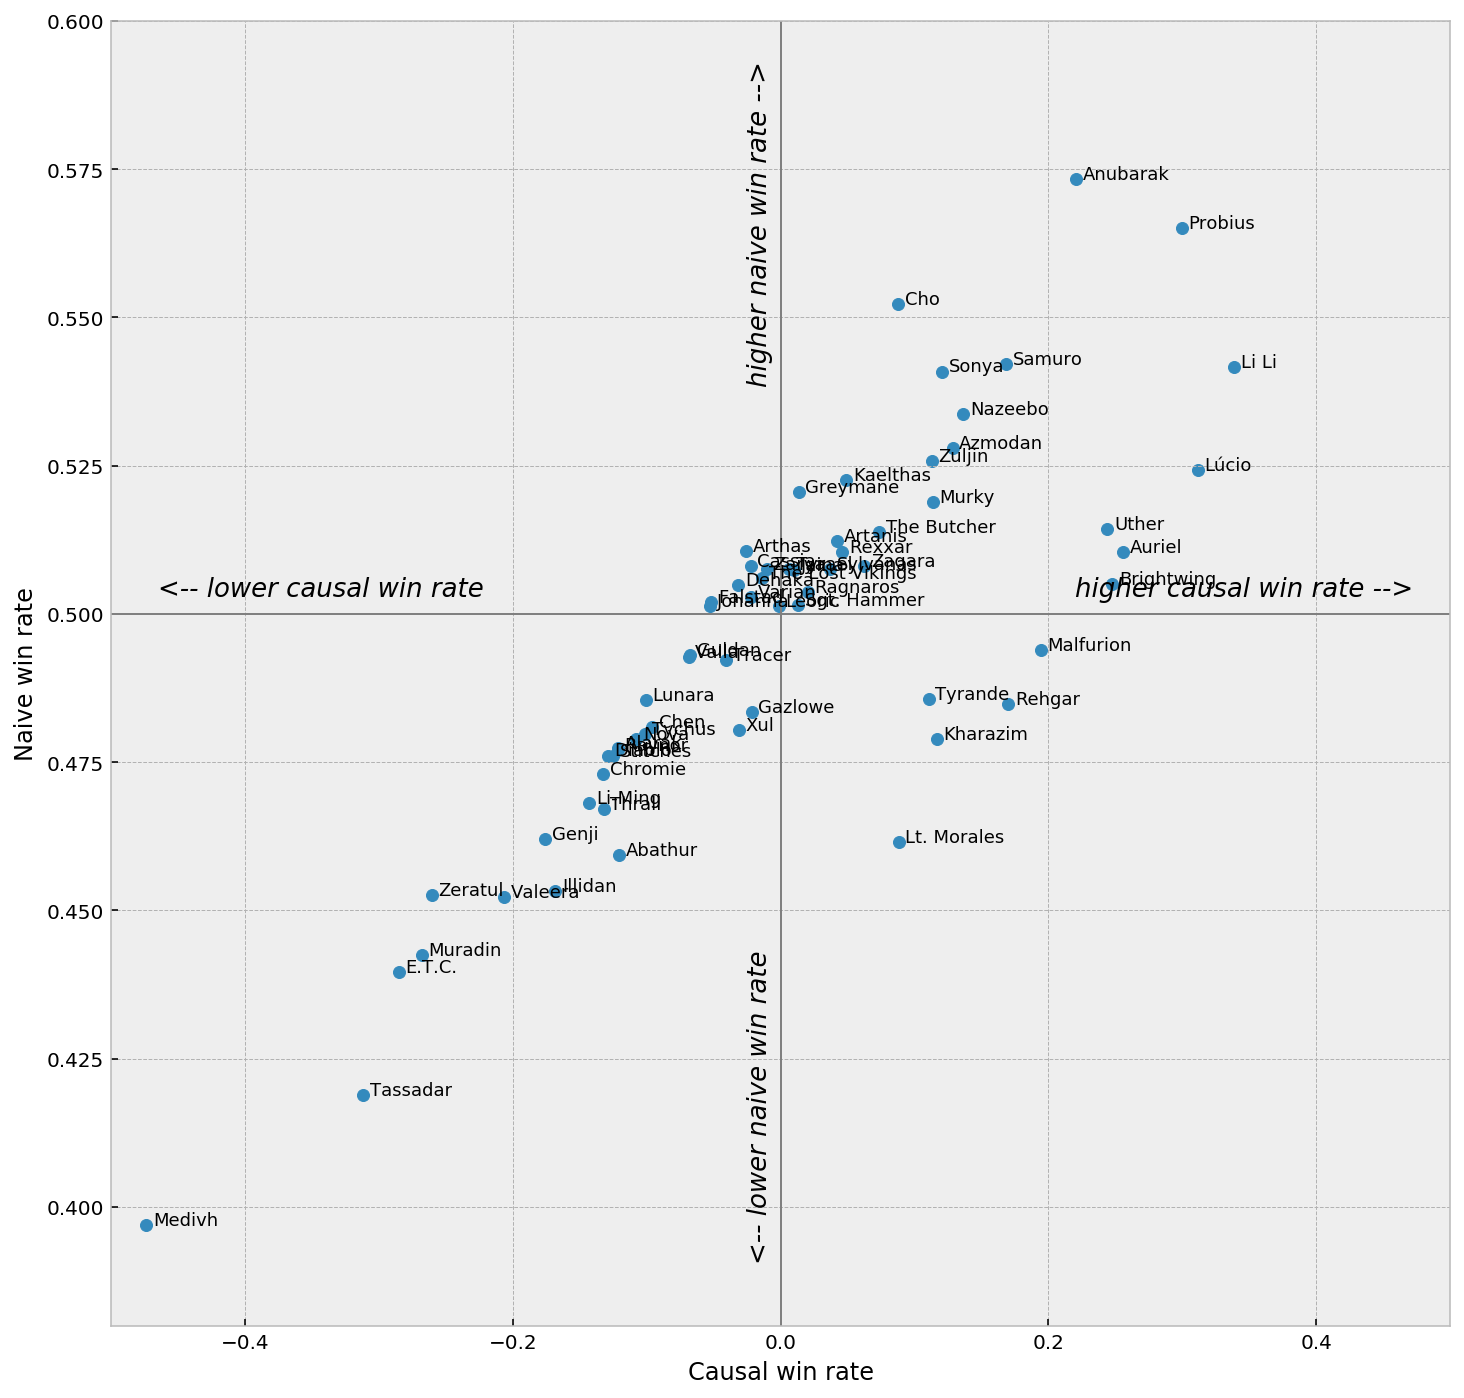

In [365]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

f, ax = plt.subplots(1,1,figsize=(12,12))
ax.scatter(x, y)

for i, txt in enumerate(x.index):
    txt = txt.lstrip("allied_char_")
    ax.annotate(txt, (x[i]+0.005, y[i]), fontsize=9)
    
#ax.set_ylabel("<--- lower naive winrate | higher naive winrate --->")

plt.hlines(0.5, -0.5, 0.5, lw=1, color='gray')
plt.vlines(0.0, 0.38, 0.6, lw=1, color='gray')

plt.xlim(-0.5, 0.5)
plt.ylim(0.38, 0.6)

ax.text(-0.025, 0.59, 'higher naive win rate -->', style='italic', rotation=90, fontsize=13)
ax.text(-0.025, 0.44, '<-- lower naive win rate', style='italic', rotation=90, fontsize=13)
ax.text(0.22, 0.503, 'higher causal win rate -->', style='italic', fontsize=13)
ax.text(-0.465, 0.503, '<-- lower causal win rate', style='italic', fontsize=13)


plt.ylabel("Naive win rate")
plt.xlabel("Causal win rate")

plt.savefig("causal_v_naive.png", bbox_inches='tight', dpi=250)

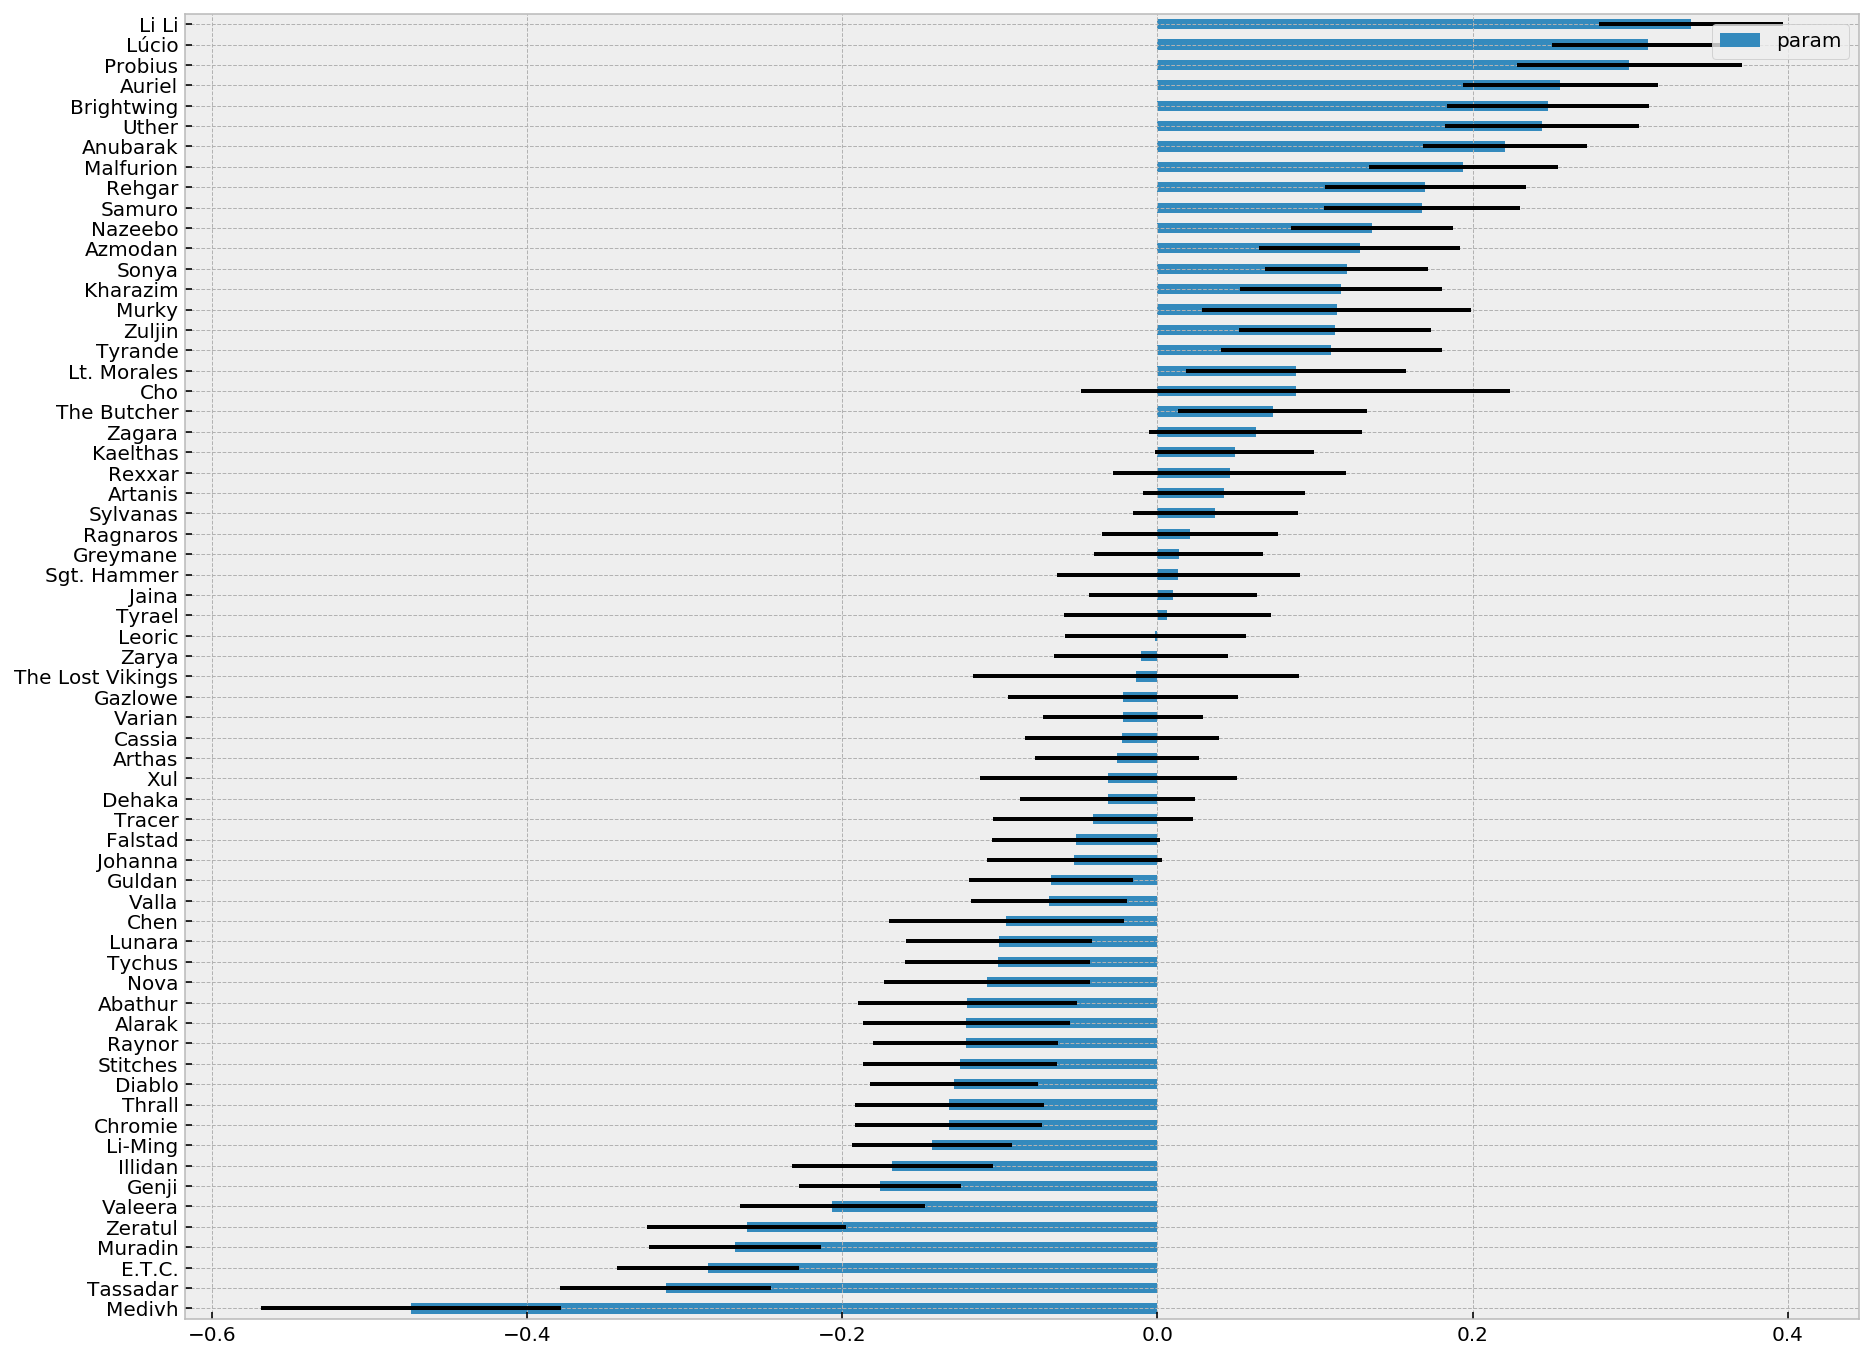

In [366]:
f, ax = plt.subplots(1,1,figsize=(15,12))

yerr = results.bse.filter(like='allied_char')

r = pd.DataFrame({'param': x, 'error': 1.96*yerr})
r.index = [_.lstrip('allied_char_') for _ in r.index]

r.sort_values('param').plot.barh(y='param', ax=ax, color='#348ABD', xerr='error', lw=0.1)
plt.savefig("coefs.png", bbox_inches='tight', dpi=250)